In [1]:
\l cureOrig.q
sample:readsam[SIMPLE_SAMPLES[`:SAMPLE_SIMPLE4]]`
/show sample:readsam[FCPS_SAMPLES[`:SAMPLE_CHAINLINK]]`
/sample:readsam[FCPS_SAMPLES[`:SAMPLE_TARGET]]`

In [2]:
dsc:{[n;r;s](r+n?s-r)*/:(cos;sin)@\:4*n?acos 0}
data :flip(-5 1)+(1 1.5)*dsc[1000; 0;1.8],'dsc[2000;3.1;4.2],'dsc[4000;5.2;6.5]
data,:flip(4 -1)+(1 8)*dsc[4000; 0;1.]
data@:neg[2000&count data]?count data
sample:data

-1.567473 -1.710713 
-1.323867 6.745647  
-10.64619 -3.684479 
4.064173  5.552103  
-5.231518 -7.445346 
0.7076635 4.846244  
4.10755   -0.6628848
-2.231592 8.533084  
4.009992  -0.6682384
-4.043703 6.258881  
-2.527246 8.824091  
1.058216  2.07053   
-8.277389 8.029361  
-6.87076  5.734845  
-5.811577 10.30938  
4.564759  0.4111338 
-1.640302 8.64057   
-4.754041 1.745347  
-3.58875  -3.324208 
-4.153694 10.10757  
3.114207  -4.289113 
3.286772  2.527686  
..


In [3]:
show sample:sample a,((til count sample) except a:sample?((asc sample)(floor(count sample)%2)))
dim:1_(til (first distinct count each sample)+1),1

In [4]:
/insert cluster into tree

insertKd1:{[kd;sample2;L;clust] 
   /check if its to the left or right of initial cluster in tree
 
 dir:{(first x[0]`idx)>=0}{[sample2;kd;x] a:x[0];
  $[first (sample2[first x[0]`dim]>(first x[0]`rDim));
  i:update left:enlist 0,right:enlist 1 from exec idx,dim,rep,rDim from kd where right=1,parent=first a`idx;
  i:update left:enlist 1,right:enlist 0 from exec idx,dim,rep,rDim from kd where left=1,parent=first a`idx];
  (i;a)}[sample2;kd]/(i;i:exec from kd where parent=0,left=0,right=0); /insert cluster into the tree by looking at splitting dimension of each node &going left or right

 
 i:dir[0];
 a:dir[1];
 dim:((first a`dim)+1)mod 2; /get its new splitting dimension


 root:kd upsert flip update idx:(max kd`idx)+1,initi:L,clust:clust,rep:enlist sample2,
    rDim:enlist sample2[dim],dim:enlist dim,valid:1b,
    parent:enlist first a`idx from exec left,right from i; /update the info of new node into tree
 root}

In [5]:
/insert cluster into tree

insertKd:{[kd;sample2;L;cl] 
   /check if its to the left or right of initial cluster in tree
 
 dir:{(first x[0]`idx)>=0}{[sample2;kd;x] a:x[0];
  $[first (sample2[first x[0]`dim]>(first x[0]`rDim));
  i:update left:enlist 0,right:enlist 1 from exec idx,dim,rep,rDim from kd where right=1,parent=first a`idx,valid;
  i:update left:enlist 1,right:enlist 0 from exec idx,dim,rep,rDim from kd where left=1,parent=first a`idx,valid];
  (i;a)}[sample2;kd]/(i;i:exec from kd where parent=0,left=0,right=0); /insert cluster into the tree by looking at splitting dimension of each node &going left or right

 i:dir[0];
 left1:i`left;
 right1:i`right;
 a:dir[1];
 dim:((first a`dim)+1)mod 2; /get its new splitting dimension
 b:exec idx from kd where valid=0b;
 root:update idx:(max kd`idx)+1, initi:L, clust:cl,rep:enlist sample2,
    valid:enlist 1b,dim:dim, rDim:sample2[dim],left:left1,right:right1,
    parent:a`idx from kd where idx=first b;  /update the info of new node into tree
 
 root}

In [6]:
/Calculating distances between clusters using kd tree. 


distC:{[kd;pt] 
 
 distCalc:{[kd;query;bestD]
   
 X:bestD[3]; / nodes that were already searched, not to be searched again
    
 cl:bestD[5]; / what cluster the node belongs to, as not to search any points in the same cluster
 n:bestD[1]; /nodes to search
 a:n where {[cl;kd;x](first exec clust from kd where idx=x,valid)<>cl}[cl;kd]each n; /nodes to search that arent in the same cluster
  
 newD:imins,a i?imins:min i:{[kd;query;x] 
    sum m*m:(raze exec rep from kd where idx=x,valid)-query}[kd;query] each a; /get minimum dist of all searched nodes

  $[(newD[0]<bestD[0])&(count a)<>0;(bestD[0]:newD[0];bestD[2]:newD[1])
     ;(bestD:bestD)]; /if new dist is less than current best dist, then that becomes new best dist
  
  axisD:(raze {[kd;bestD;query;x] $[(m*m:
    (first exec rDim from kd where idx=x,valid)-
    query(first exec dim from kd where idx=x,valid))<=bestD[0];
    (exec idx from kd where parent=x,valid),exec parent from kd where idx=x,valid;
    $[(query(first exec dim from kd where idx=x,valid))<
    first exec rDim from kd where idx=x,valid;
    (exec idx from kd where parent=x,left=1,valid),exec parent from kd where idx=x,valid;
    (exec idx from kd where parent=x,right=1,valid),exec parent from kd where idx=x,valid]]
    }[kd;bestD;query]each n)except bestD[3]:X,n; /get dists between node and search pts based on splitting dimension.
    /if =< than best Dist, than search the children of that node &parents.
    /Go up the tree and to the left/right based on whether that pt is <or> search pt
  
 (bestD[0];distinct axisD;bestD[2];bestD[3];bestD[4];cl)};
 dist:{[distCalc;kd;X] ({(count x[1])<>0}distCalc[kd;
    raze exec rep from kd where idx=X,valid]/(0W;
    (raze (exec idx from kd where parent=X,valid),exec parent from kd where idx=X,valid)except X;X;X;X
    ;first exec clust from kd where idx=X))
    }[distCalc;kd;pt];
    
    kdC:update closDist:dist[0],closIdx:dist[2] from kd where idx=pt; /update new closDist and idx in tree
    kdC}

In [26]:
/ delete from kd tree

deleteN:{[kd;X] 
 n:first exec idx from kd where initi=X,valid;
 delN:{
  kd:x[0]; /kdtree
  X:x[1]; /point to be deleted
  delNode:select from kd where idx=X,valid; /details of deleted pt
  axis:delNode`dim; /splitting dim

  mindim:$[(count exec idx from kd where right=1,parent=X,valid)=0;
    raze {[kd;x](count exec idx from kd where
       parent=first x,valid)<>0}[kd]{[kd;x]raze exec idx from kd where parent in x,valid}[kd]\
    first exec idx from kd where parent=X,left=1,valid; / if has no right child then left child replaces 
    raze {[kd;x] (count exec idx from kd where
       parent=first x,valid)<>0}[kd]{[kd;x]raze exec idx from kd where parent in x,valid}[kd]\
    first exec idx from kd where parent=X,right=1,valid]; / get all the right children if there

  newP:mindim repPt?min repPt:(raze{[kd;x] exec rep from kd where idx=x,valid}[kd]each mindim)axis; /the min value of rep pts from mindim based on splitting dimension
  newNode:select from kd where idx=newP,valid; /get info from kdtree of newP
  tree:update rep:newNode`rep,initi:newNode`initi,closDist:newNode`closDist,
    clust:newNode`clust,clustIdx:newNode`clustIdx,rDim:(first newNode`rep)axis,
    closIdx:newNode`closIdx from kd where idx=X,valid; /newNode replaces the deleted pt info in the tree, but dim and idx stay the same as deleted pt
  

  tree:update closIdx:X from tree where closIdx=first newNode`idx,valid; /any pt that had the replacing pt as its closest idx has to update closIdx to its new value in the tree
  

    (tree;newP)};

 delCl:{(count select from (first x) where parent=last x,valid)<>0}delN/(kd;n); /repeat this until reach a node with no children
 
 
 update valid:0b from first delCl where idx=last delCl} /delete the node with no children

In [ ]:
deleteN:{[kd;X]
 n:first exec idx from kd where initi=X,valid;
 delN:{
  kd:x[0]; /kdtree
  X:x[1]; /point to be deleted
  delNode:kd X; /details of deleted pt
  axis:delNode`dim; /splitting dim

  mindim:$[(count exec idx from kd where right=1,parent=X,valid)=0;
    raze {[kd;x](count exec idx from kd where
       parent in x,valid)<>0}[kd]{[kd;old;x]old,raze exec idx from kd where parent in x,valid}[kd]/
    first exec idx from kd where parent=X,left=1,valid; / if has no right child then left child replaces
    raze {[kd;x] (count exec idx from kd where
       parent in x,valid)<>0}[kd]{[kd;x]raze exec idx from kd where parent in x,valid}[kd]/
    first exec idx from kd where parent=X,right=1,valid]; / get all the right children if there

  newP:mindim repPt?min repPt:(raze{[kd;x] exec rep from kd where idx=x,valid}[kd]each mindim)axis; /the min value of rep pts from mindim based on splitting dimension
  newNode:kd newP; /get info from kdtree of newP
  tree:update rep:enlist newNode`rep,initi:newNode`initi,closDist:newNode`closDist,
    clust:newNode`clust,clustIdx:enlist newNode`clustIdx,rDim:(newNode`rep)axis,
    closIdx:newNode`closIdx from kd where idx=X,valid; /newNode replaces the deleted pt info in the tree, but dim and idx stay the same as deleted pt


  tree:update closIdx:X from tree where closIdx=first newNode`idx,valid; /any pt that had the replacing pt as its closest idx has to update closIdx to its new value in the tree


    (tree;newP)};

 delCl:{(count select from (first x) where parent=last x,valid)<>0}delN/(kd;n); /repeat this until reach a node with no children


 update valid:0b from first delCl where idx=last delCl} /delete the node with no children


In [ ]:
$[(count pts)<=numR;(rep:pts;sami:idxs);rep:sample sami:numR{[sample;idxs;x] x,maxIdx imax
  {[sample;maxMean;x] min{[sample;x;maxMean]sum x*x:sample[maxMean]-sample[x]
     }[sample;x] each maxMean}[sample;x]each maxIdx:idxs except x
  }[sample;idxs]/maxFromMean:idxs imax sum each{x*x}mean-/:pts];

In [8]:
/Create tree, search init nearest neighbours


root:flip `idx`initi`rep`left`right`dim`parent`rDim`clust`clustIdx`valid!
   (0;0;enlist sample[0];enlist 0;enlist 0;enlist 0;enlist 0;enlist sample[0;0];0;enlist (0 0);enlist 1b);

kds:insertKd1/[root;(1_sample);1_til count sample;1_til count sample]

kds:update clustIdx:enlist each til count sample from kds

show kds:distC/[kds;kds`initi]

idx initi rep                  left right dim parent rDim       clust clustId..
-----------------------------------------------------------------------------..
0   0     -1.567473 -1.710713  0    0     0   0      -1.567473  0     0      ..
1   1     -1.323867 6.745647   0    1     1   0      6.745647   1     1      ..
2   2     -10.64619 -3.684479  1    0     1   0      -3.684479  2     2      ..
3   3     4.064173  5.552103   1    0     0   1      4.064173   3     3      ..
4   4     -5.231518 -7.445346  1    0     0   2      -5.231518  4     4      ..
5   5     0.7076635 4.846244   1    0     1   3      4.846244   5     5      ..
6   6     4.10755   -0.6628848 0    1     1   3      -0.6628848 6     6      ..
7   7     -2.231592 8.533084   0    1     0   2      -2.231592  7     7      ..
8   8     4.009992  -0.6682384 1    0     0   5      4.009992   8     8      ..
9   9     -4.043703 6.258881   1    0     1   7      6.258881   9     9      ..
10  10    -2.527246 8.824091   0    1   

In [12]:
/Create tree, search init nearest neighbours
createTree:{[sample]

 root:flip `idx`initi`rep`left`right`dim`parent`rDim`clust`clustIdx`valid!
   (0;0;enlist sample[0];enlist 0;enlist 0;enlist 0;enlist 0;enlist sample[0;0];0;enlist (0 0);1b); /insert first cluster

 kds:insertKd1/[root;(1_sample);1_til count sample;1_til count sample]; /insert the rest of the clusters

 kds:update clustIdx:enlist each til count sample from kds; /insert the cluster indices

 kds:distC/[kds;kds`initi]; /get closest cluster to each cluster
 kds
 }


In [ ]:
createTree sample

In [9]:
numR:50
com:0
numCl:4

\ts clust:{[numCl;kd] (count distinct (select from kd where valid)`clust)>numCl}[numCl]{[sample;numR;com;kd]
 kd2:select from kd where valid;
 j:first select from kd2 where closDist=min closDist;
 
 j2:select clust from kd where idx=first j`closIdx,valid;
 
 old:select from kd where clust in ((j2`clust),j`clust),valid;
 j0:(exec initi from kd where closIdx in old`idx,valid);
 
 mean:avg pts:sample idxs:(distinct raze old`clustIdx);
 
 deleteClust:deleteN/[kd;idxs];
 
 maxFromMean:idxs imax sum each{x*x}mean-/:pts;
 
 rep:distinct sample sami:numR{[sample;idxs;x] x,maxIdx imax {[sample;maxMean;x] min{[sample;x;maxMean]sum x*x:sample[maxMean]-sample[x]
     }[sample;x] each maxMean}[sample;x]each maxIdx:idxs except x}[sample;idxs]/maxFromMean;
 
 rep:(rep*1-com)+\:com*mean;
 a:{[rep;x]min (sum each x*x:rep-\:x)}[rep]each (exec rep from deleteClust where valid);
 j3:(exec idx from deleteClust where valid)[n:where a<(exec closDist from deleteClust where valid)];
 b: (exec idx from deleteClust where valid)where a=c:min a;
 insertClust:insertKd/[deleteClust;rep;sami;(first idxs)];
 insertClust2:$[(count j3)=0;insertClust;{[n;j3;a;insertClust;x] update closDist:a(n x)
  ,closIdx:enlist (max (insertClust`idx)) from 
    insertClust where idx=j3(x)}[n;j3;a]/[insertClust;til count j3]];

 clustDist:update closIdx:first b,closDist:c from insertClust2 where clust=first idxs;
 /clustDist:distC/[insertClust2; j5:exec idx from insertClust2 where clust=first idxs];
 j5:exec idx from insertClust2 where clust=first idxs,valid;
 j4:(exec idx from clustDist where initi in j0,valid) except j5;

 recalc:distC/[clustDist;j4];
 insertIdx:enlist idxs;
 kd:{[insertIdx;kd;x] update clustIdx:insertIdx from kd where initi=x,valid}[insertIdx]/[recalc;sami];
  kd}[sample;numR;com]/kds

55121 1621184


In [30]:
clust:{[sample;numR;com;kd]
 kd2:select from kd where valid;
 j:first select from kd2 where closDist=min closDist;
 
 j2:select clust from kd2 where idx=first j`closIdx;
 
 old:select from kd2 where clust in ((j2`clust),j`clust);
 j0:(exec initi from kd2 where closIdx in old`idx);
 
 mean:avg pts:sample idxs:(distinct raze old`clustIdx);
 
 deleteClust:deleteN/[kd;idxs];
 
 maxFromMean:idxs imax sum each{x*x}mean-/:pts;
 
 rep:distinct sample sami:numR{[sample;idxs;x] x,maxIdx imax {[sample;maxMean;x] min{[sample;x;maxMean]sum x*x:sample[maxMean]-sample[x]
     }[sample;x] each maxMean}[sample;x]each maxIdx:idxs except x}[sample;idxs]/maxFromMean;
 
 rep:(rep*1-com)+\:com*mean;
 a:{[rep;x]min (sum each x*x:rep-\:x)}[rep]each (exec rep from deleteClust where valid);
 j3:(exec idx from deleteClust where valid)[n:where a<(exec closDist from deleteClust where valid)];
 b: (exec idx from deleteClust where valid)where a=c:min a;
 insertClust:insertKd/[deleteClust;rep;sami;(first idxs)];
 insertClust2:$[(count j3)=0;insertClust;{[n;j3;a;insertClust;x] update closDist:a(n x)
  ,closIdx:enlist (max (insertClust`idx)) from 
    insertClust where idx=j3(x)}[n;j3;a]/[insertClust;til count j3]];

 clustDist:update closIdx:first b,closDist:c from insertClust2 where clust=first idxs;
 /clustDist:distC/[insertClust2; j5:exec idx from insertClust2 where clust=first idxs];
 j5:exec idx from insertClust2 where clust=first idxs,valid;
 j4:(exec idx from clustDist where initi in j0,valid) except j5;

 recalc:distC/[clustDist;j4];
 insertIdx:enlist idxs;

  kd:{[insertIdx;kd;x] update clustIdx:(insertIdx) from kd where initi=x,valid}[insertIdx]/[recalc;sami]; /update into kdtree

  kd}


In [31]:
cure:{[sample;numR;com;numCl] 
 cureTab:{[numCl;kd] (count distinct (select from kd where valid)`clust)>numCl}[numCl]clust[sample;numR;com]/createTree sample;
 distinct (select from cureTab where valid)`clustIdx}

In [18]:
sample:get`:sample

In [32]:
aa:cure[sample;50;0;4]

In [35]:
/show r:distinct (select from aa where valid)`clustIdx
bb:get`:aa
r:bb

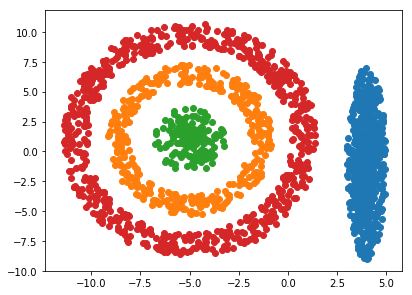

In [36]:
{plt[`:scatter][;]. flip sample[x]}each r;
plt[`:show][];

587
